## Which are organizations or political figures do they tweet about?  What sentiments do they demonstrate when discussing these entities?
### Named entity recognition and sentiment analysis

In [1]:
import re
import numpy as np
import random
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from spacy import displacy
from collections import Counter
import en_core_web_md
nlp = en_core_web_md.load()

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
eng_tweets = pd.read_pickle('../data/eng_tweets.p')

In [3]:
eng_tweets.content = eng_tweets.content.apply(lambda x: re.sub(r'"''~',"",str(x)))

In [4]:
eng_tweets.content.head()

0    We have a sitting Democrat US Senator on trial...
1    Marshawn Lynch arrives to game in antiTrump sh...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN President Trump dedicates Presidents C...
4    19000 RESPECTING our National Anthem StandForO...
Name: content, dtype: object

In [5]:
targets = ['RightTroll', 'LeftTroll', 'Newsfeed']
eng_tweets = eng_tweets.loc[eng_tweets.account_category.isin(targets)]

In [6]:
eng_tweets.shape

(1031417, 18)

In [7]:
subset = eng_tweets

In [8]:
#entities = []
#labels = []
#sentences = []
#for tweet in subset.content:
#    doc = nlp(tweet)
#    entities.append([ent.text for ent in doc.ents])
#    labels.append([ent.label_ for ent in doc.ents])
#    sentences.append([sent for sent in doc.sents])

In [9]:
subset['docs'] = subset.content.apply(nlp)

In [10]:
subset['entities'] = subset.docs.apply(lambda doc: [ent.text for ent in doc.ents])

In [11]:
subset['labels'] = subset.docs.apply(lambda doc: [ent.label_ for ent in doc.ents])

In [12]:
subset['sentences'] = subset.docs.apply(lambda doc: [sent for sent in doc.sents])

In [13]:
flattened_entities = subset.entities.tolist()
flattened_entities = pd.Series([str(item) for sublist in flattened_entities for item in sublist])

flattened_labels = subset.labels.tolist()
flattened_labels = pd.Series([str(item) for sublist in flattened_labels for item in sublist])

In [14]:
flattened_entities.loc[0:10]

0           Democrat
1                 US
2     Marshawn Lynch
3              Lynch
4               Navy
5                NFL
6         BoycottNFL
7              Trump
8            Florida
9              Texas
10       Puerto Rico
dtype: object

In [15]:
flattened_labels.loc[0:10]

0       NORP
1        GPE
2     PERSON
3     PERSON
4        ORG
5        ORG
6        ORG
7     PERSON
8        GPE
9        GPE
10       GPE
dtype: object

In [16]:
top20 = Counter(flattened_entities).most_common(20)
top20

[('Trump', 25002),
 ('Obama', 19551),
 ('US', 16130),
 ('Hillary', 14378),
 ('America', 12522),
 ('CNN', 10958),
 ('2', 8750),
 ('GOP', 8468),
 ('today', 8254),
 ('American', 8084),
 ('one', 7669),
 ('POTUS', 7531),
 ('Russia', 6882),
 ('ISIS', 6639),
 ('first', 6255),
 ('Americans', 5995),
 ('Democrats', 5837),
 ('Clinton', 5806),
 ('MAGA', 5698),
 ('4', 5131)]

In [17]:
people = flattened_entities.loc[flattened_labels=='PERSON']
top20people = Counter(people).most_common(20)
top20people = [x[0] for x in top20people]
top20people

['Hillary',
 'Obama',
 'Hillary Clinton',
 'Donald Trump',
 'Clinton',
 'Trump',
 'Trumps',
 'Bernie',
 'Putin',
 'Comey',
 'Bill Clinton',
 'Jesus',
 'Bernie Sanders',
 'McMaster',
 'Soros',
 'Ted Cruz',
 'Michelle Obama',
 'Mueller',
 'Barack Obama',
 'Clintons']

In [18]:
org = flattened_entities.loc[flattened_labels=='ORG']
top20org = Counter(org).most_common(20)
top20org = [x[0] for x in top20org]
top20org

['Trump',
 'Obama',
 'CNN',
 'GOP',
 'POTUS',
 'ISIS',
 'MAGA',
 'FBI',
 'NFL',
 'PJNET',
 'Congress',
 'FoxNews',
 'FAKENEWS',
 'Islam',
 'HillaryClinton',
 'DNC',
 'Senate',
 'realDonaldTrump',
 'USFA',
 'Obamacare']

In [19]:
for i in range(20):
    displacy.render(nlp(str(subset.sentences.loc[i])), jupyter=True, style='ent')

In [20]:
subset['sentiment'] = subset.content.astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

In [21]:
def get_polarity(sentiment):
    if sentiment > 0.0:
        return 'Positive'
    if sentiment < 0.0:
        return 'Negative'
    else:
        return 'Neutral'
subset['polarity'] = subset.sentiment.apply(get_polarity)

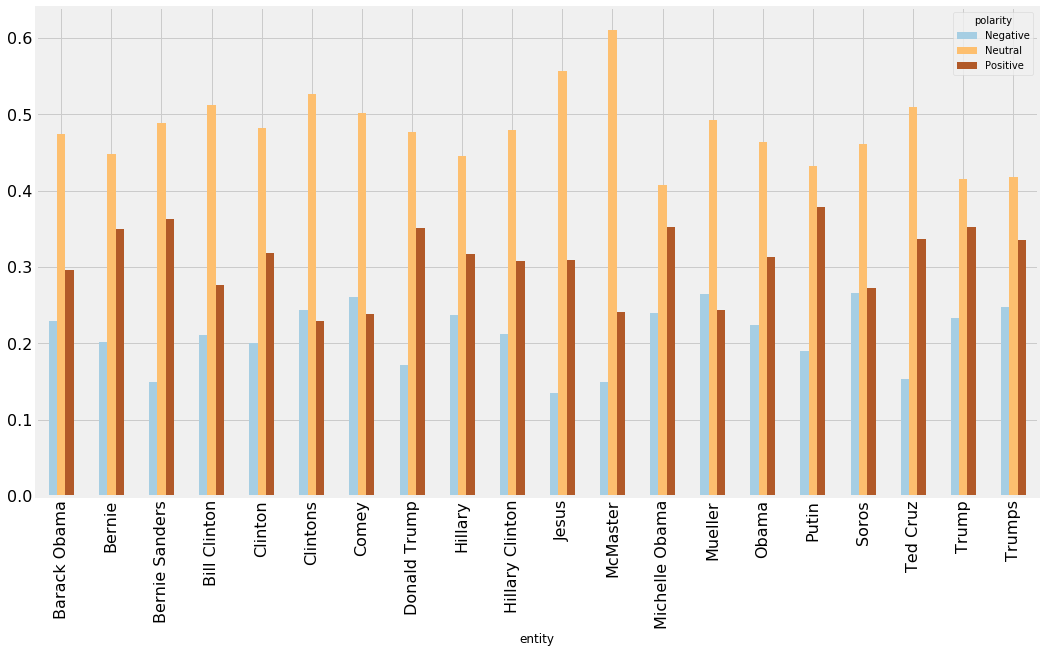

In [22]:
top20people_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20people))])
top20people_polarity = (top20people_polarity.entities.apply(pd.Series)
                        .merge(top20people_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20people_polarity = (top20people_polarity.loc[top20people_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20people))])
top20people_polarity = top20people_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
top20people_polarity.plot(kind = 'bar', figsize=(16,9), colormap='Paired', fontsize=16)
#top20people_polarity

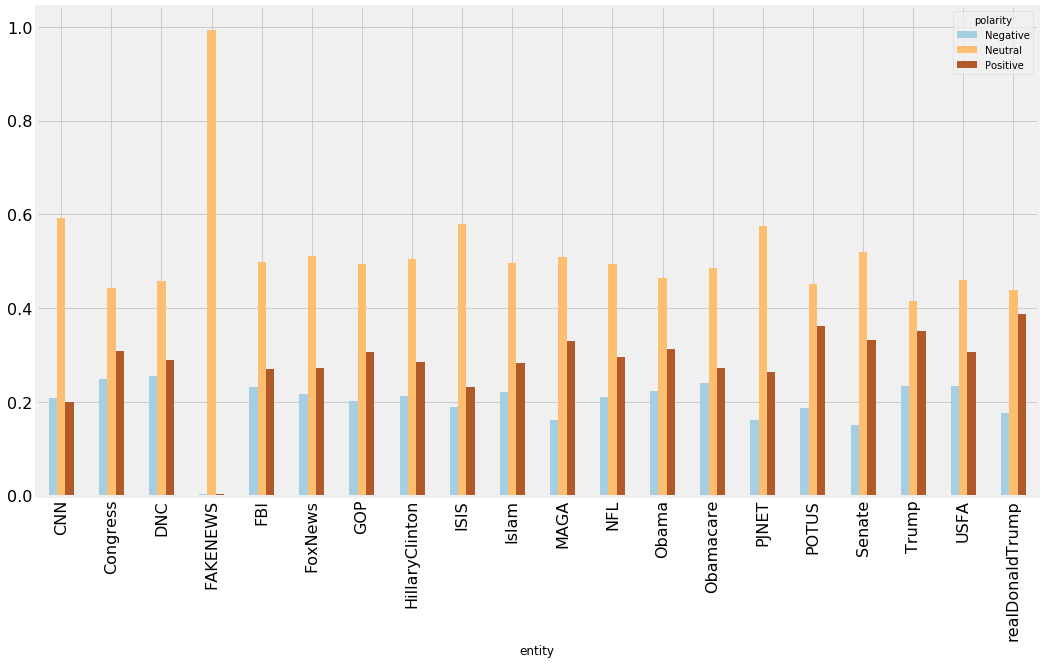

In [23]:
top20org_polarity = (subset[['entities','polarity']].loc[subset.content
                        .apply(lambda string: any(x in string for x in top20org))])
top20org_polarity = (top20org_polarity.entities.apply(pd.Series)
                        .merge(top20org_polarity, left_index = True, right_index = True)
                        .drop(['entities'], axis = 1)
                        .melt(id_vars = ['polarity'], value_name = 'entity')
                        .drop(['variable'], axis=1)
                       )
top20org_polarity = (top20org_polarity.loc[top20org_polarity.entity
                        .apply(lambda string: any(x == str(string) for x in top20org))])
top20org_polarity = top20org_polarity.groupby(['entity','polarity']).size().groupby(level = 0).transform(lambda x: x/x.sum()).unstack()
top20org_polarity.plot(kind = 'bar', figsize=(16,9), colormap='Paired', fontsize=16)
#top20people_polarity

In [24]:
subset.to_csv('../data/eng_tweets_with_entities.csv')